In [ ]:
import sys
import os
import collections
import json
from itertools import cycle
from ast import literal_eval
from dataclasses import dataclass, asdict
from typing import Any, Callable, Dict, List, NewType, Optional, Tuple, Union
from pathlib import Path
from datetime import datetime
from tqdm.auto import tqdm, trange

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler
from torch import optim
from torch.optim import lr_scheduler
# import torchmetrics
# from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from transformers import *
# from transformers.modeling_outputs import SequenceClassifierOutput, ModelOutput

import matplotlib.pyplot as plt
from IPython.display import display

In [ ]:
result_folder = os.environ["scratch_result_folder"] if "scratch_result_folder" in os.environ else '../result'
scratch_data_folder = os.environ["scratch_data_folder"] if "scratch_data_folder" in os.environ else None
repo_folder = os.environ["style_models_repo_folder"] if "style_models_repo_folder" in os.environ else None
data_folder = f"{repo_folder}/data" if repo_folder else '../data'

In [ ]:
# the distribution of num of tokens will give an intuition on 
# how to determine the best number of max_length when modeling 
# using bert tokenizer. however, different tokenizer might give slightly different tokens
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased') 

# helper functions for pan22

In [ ]:
def create_df(dataset_idx, split):
    df = pd.DataFrame()
    folder = f"{data_folder}/pan22/dataset{dataset_idx}/{split}"
    if split != 'test':
        num_docs = len(os.listdir(folder))//2
    else:
        num_docs = len(os.listdir(folder))

    for i in trange(1,num_docs+1, leave=False):
        item = {}
        text_file = f"problem-{i}.txt"
        truth_file = f"truth-problem-{i}.json"
        item['i'] = i
    #     item['text_file'] = text_file
    #     item['truth_file'] = truth_file

        with open(f"{folder}/{text_file}") as f:
            doc = f.readlines()
        tokens = []
        para_lens = []
        for para in doc:
            para_tokens = tokenizer.tokenize(para)
            tokens.append(para_tokens)
            para_lens.append(len(para_tokens))
        item['doc'] = doc
        item['tokens'] = tokens # using bert tokenizer. different tokenizer might give slightly different tokens
        item['para_lens'] = para_lens
        item['doc_len'] = len(doc)
        
        if split != 'test':
            with open(f"{folder}/{truth_file}") as f:
                truth = json.load(f)

            item['num_authors'] = truth['authors']
            item['site'] = truth['site']
            item['multi-author'] = truth['multi-author']
            item['changes'] = truth['changes']
            item['paragraph-authors'] = truth['paragraph-authors']

        df = df.append(item, ignore_index=True)
    return df

In [ ]:
def visualize(df, split):
    num_plots = 3 if split != 'test' else 2
    plt.figure(figsize=(15 if split != 'test' else 10,4))
    plt.suptitle(f'{split} data distribution', fontsize=20)
    plt.subplot(1,num_plots,1)
    plt.title('doc_len distribution')
    plt.hist(df['doc_len'], bins=int(df['doc_len'].max()))
    plt.text(0.8*max(df['doc_len'].tolist()), 0, f"max:{int(max(df['doc_len'].tolist()))}", fontsize=16)
    plt.subplot(1,num_plots,2)
    plt.title('para_lens distribution')
    plt.hist([para_len for doc_para_len in df['para_lens'] for para_len in doc_para_len], bins=100)
    max_para_len = max([para_len for doc_para_len in df['para_lens'] for para_len in doc_para_len])
    plt.text(0.8*max_para_len,0, f"max:{max_para_len}", fontsize=16)
    if split != 'test':
        plt.subplot(1,num_plots,3)
        plt.title('num_authors distribution')
        plt.hist(df['num_authors'], bins=int(df['num_authors'].max()))
        plt.text(max(df['num_authors'].tolist()), 0, f"max:{int(max(df['num_authors'].tolist()))}", fontsize=16)
    plt.show()

# pan22 dataset 1

  0%|          | 0/1400 [00:00<?, ?it/s]

,i,doc_len,num_authors,multi-author
count,1400.0000,1400.000000,1400.0,1400.0
mean,700.5000,7.849286,2.0,1.0
std,404.2895,4.392566,0.0,0.0
min,1.0000,2.000000,2.0,1.0
25%,350.7500,6.000000,2.0,1.0
50%,700.5000,7.000000,2.0,1.0
75%,1050.2500,9.000000,2.0,1.0
max,1400.0000,80.000000,2.0,1.0


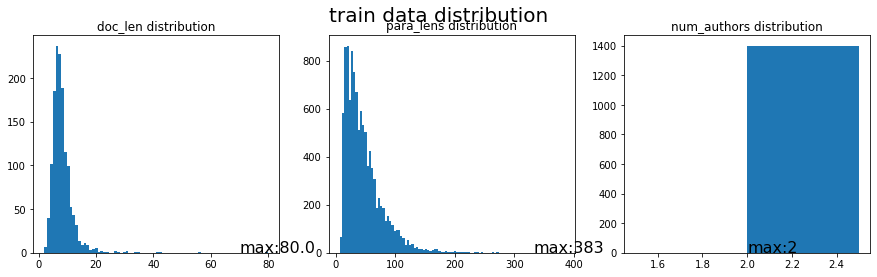

  0%|          | 0/300 [00:00<?, ?it/s]

,i,doc_len,num_authors,multi-author
count,300.000000,300.000000,300.0,300.0
mean,150.500000,8.136667,2.0,1.0
std,86.746758,6.327568,0.0,0.0
min,1.000000,2.000000,2.0,1.0
25%,75.750000,6.000000,2.0,1.0
50%,150.500000,7.000000,2.0,1.0
75%,225.250000,9.000000,2.0,1.0
max,300.000000,72.000000,2.0,1.0


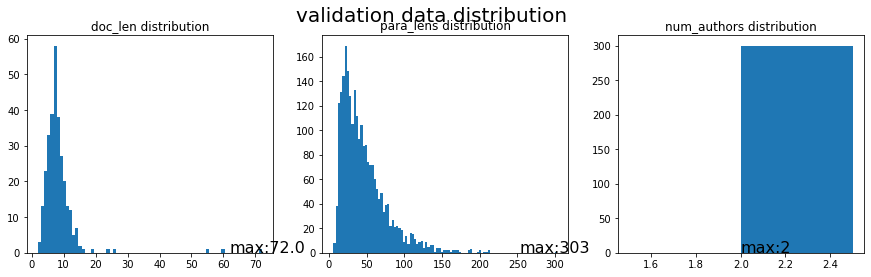

  0%|          | 0/300 [00:00<?, ?it/s]

,i,doc_len
count,300.000000,300.000000
mean,150.500000,8.106667
std,86.746758,4.045141
min,1.000000,2.000000
25%,75.750000,6.000000
50%,150.500000,7.000000
75%,225.250000,10.000000
max,300.000000,47.000000


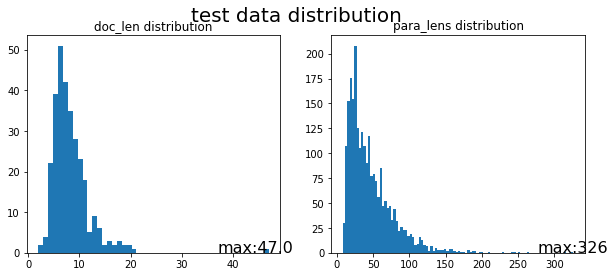

In [ ]:
for split in ['train', 'validation', 'test']:
    df = create_df(1, split)
    display(df.describe())
    visualize(df, split)

# pan22 dataset 2

  0%|          | 0/7000 [00:00<?, ?it/s]

,i,doc_len,num_authors,multi-author
count,7000.000000,7000.000000,7000.000000,7000.000000
mean,3500.500000,7.531857,3.000000,0.800000
std,2020.870275,3.422126,1.414315,0.400029
min,1.000000,2.000000,1.000000,0.000000
25%,1750.750000,5.000000,2.000000,1.000000
50%,3500.500000,7.000000,3.000000,1.000000
75%,5250.250000,9.000000,4.000000,1.000000
max,7000.000000,35.000000,5.000000,1.000000


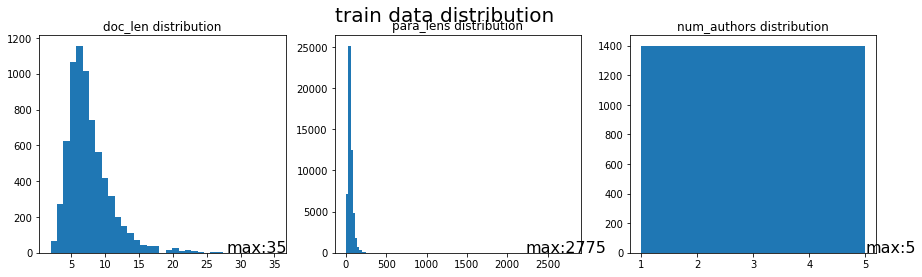

  0%|          | 0/1500 [00:00<?, ?it/s]

,i,doc_len,num_authors,multi-author
count,1500.000000,1500.000000,1500.000000,1500.000000
mean,750.500000,7.358000,3.000000,0.800000
std,433.157015,3.435167,1.414685,0.400133
min,1.000000,2.000000,1.000000,0.000000
25%,375.750000,5.000000,2.000000,1.000000
50%,750.500000,7.000000,3.000000,1.000000
75%,1125.250000,9.000000,4.000000,1.000000
max,1500.000000,34.000000,5.000000,1.000000


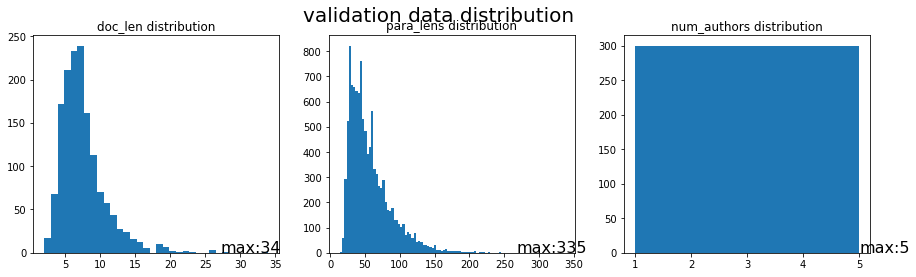

  0%|          | 0/1500 [00:00<?, ?it/s]

,i,doc_len
count,1500.000000,1500.000000
mean,750.500000,7.595333
std,433.157015,3.578843
min,1.000000,2.000000
25%,375.750000,5.000000
50%,750.500000,7.000000
75%,1125.250000,9.000000
max,1500.000000,30.000000


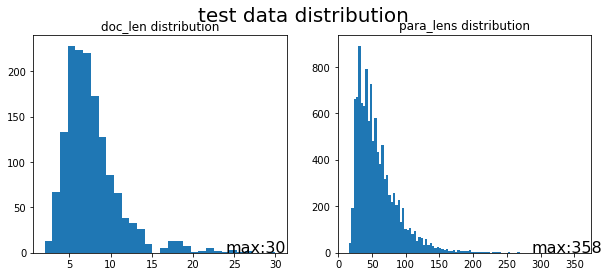

In [ ]:
for split in ['train', 'validation', 'test']:
    df = create_df(2, split)
    display(df.describe())
    visualize(df, split)

# pan22 dataset 3

  0%|          | 0/7000 [00:00<?, ?it/s]

,i,doc_len,num_authors,multi-author
count,7000.000000,7000.000000,7000.000000,7000.000000
mean,3500.500000,15.998857,3.000000,0.800000
std,2020.870275,7.888004,1.414315,0.400029
min,1.000000,4.000000,1.000000,0.000000
25%,1750.750000,11.000000,2.000000,1.000000
50%,3500.500000,14.000000,3.000000,1.000000
75%,5250.250000,19.000000,4.000000,1.000000
max,7000.000000,94.000000,5.000000,1.000000


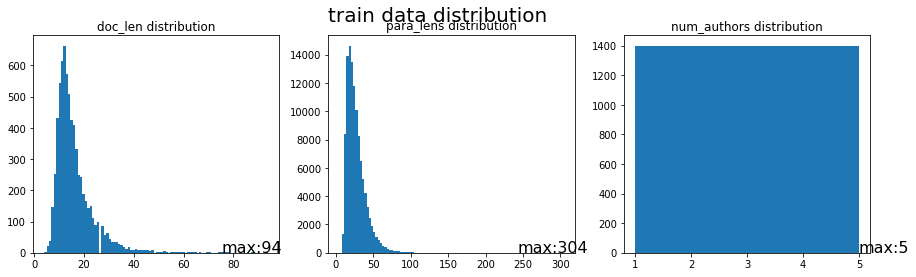

  0%|          | 0/1500 [00:00<?, ?it/s]

,i,doc_len,num_authors,multi-author
count,1500.000000,1500.000000,1500.000000,1500.000000
mean,750.500000,15.736667,3.000000,0.800000
std,433.157015,7.431115,1.414685,0.400133
min,1.000000,4.000000,1.000000,0.000000
25%,375.750000,11.000000,2.000000,1.000000
50%,750.500000,14.000000,3.000000,1.000000
75%,1125.250000,19.000000,4.000000,1.000000
max,1500.000000,99.000000,5.000000,1.000000


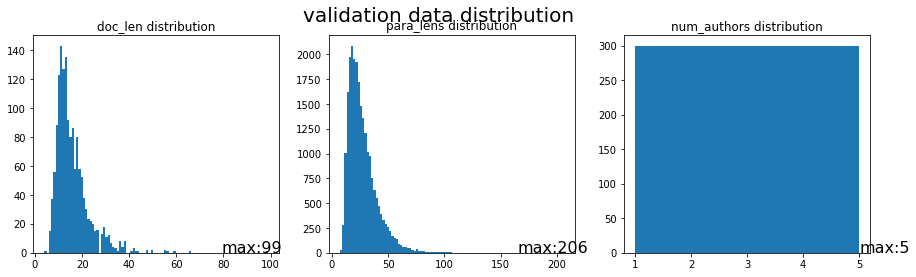

  0%|          | 0/1500 [00:00<?, ?it/s]

,i,doc_len
count,1500.000000,1500.000000
mean,750.500000,16.036667
std,433.157015,7.865064
min,1.000000,4.000000
25%,375.750000,11.000000
50%,750.500000,14.000000
75%,1125.250000,19.000000
max,1500.000000,76.000000


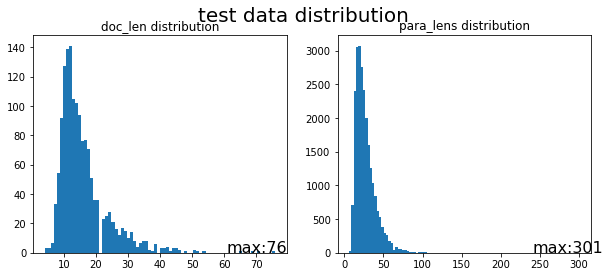

In [ ]:
for split in ['train', 'validation', 'test']:
    df = create_df(3, split)
    display(df.describe())
    visualize(df, split)